# Deep Convolutional - Image Colorization Using LAB ColorSpace
Image colorization of grayscale/luminance to LABs green and blue component. Combined with the grayscale creates a RGB Image.

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.3 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io

In [2]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
import PIL
import PIL.Image

/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Import all Modules and Configure GPU

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # Debug only
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

tf.config.experimental.enable_tensor_float_32_execution(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# Initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2023-05-20 08:13:42.997606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 08:13:43.217384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 08:13:43.217837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 08:13:43.223213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
tf.__version__


'2.9.3'

### Setup Result Directory

In [5]:
root_dir = "result/stylized_colorizing_lab_color_space"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [6]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        #ds = ds.cache(filename='/tmp/StylizedColorizing', name='StylizedColorizing')
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab_lumiance_only(img):
        image = tf.cast(img, tf.float32)

        lab = tfio.experimental.color.rgb_to_lab(image)
        l = lab[..., 0]

        l = tf.expand_dims(l, axis=-1)
        return tf.cast(tf.concat(l, axis=-1), tf.float32)

    @tf.function
    def preprocess_lab_color_only(img):
        image = tf.cast(img, tf.float32)
        lab = tfio.experimental.color.rgb_to_lab(image)
        a = lab[..., 1]
        b = lab[..., 2]

        a = tf.expand_dims(a, axis=-1)
        b = tf.expand_dims(b, axis=-1)
        return tf.cast(tf.concat([a, b], axis=-1), tf.float32)


    # Translate [0,255] -> [-128, 128]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab_lumiance_only(normalization_layer(x))))

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = (test_ds.map(lambda x: (preprocess_lab_color_only(normalization_layer(x)) * (1.0 / 128.0))))

    train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds))
    
    return configure_for_performance(train_ds, AUTOTUNE, 0)


In [7]:
#
BATCH_SIZE_PER_REPLICA = 16
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

IMAGE_SIZE = (128, 128)
EPOCHS = 8

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE, 0.95)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

IMAGE_SIZE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

Found 1263538 files belonging to 1 classes.
Found 1263538 files belonging to 1 classes.
Number of batches 78972 of 16 elements


## Augment Data

In [8]:

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

def AgumentFunc(x,y):
    return (trainAug(x), trainAug(y))

# apply augmentation image transformation to prevent overfitting.
trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Split data into train and validation
ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)
#Split data into train and validation
train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
val_ds = val_ds.with_options(options)

In [9]:


def generateBigBridImage(model, num_colm, dataset):

    train_batch_iter = iter(dataset)
    train_image_batch, expected_image_batch = next(train_batch_iter)
    
    #generated_images = model(latent_space, training=False)

    fig = plt.figure(figsize=(10 * 2, 12))
    for i in range(0, 5):

        trainImage, expectedImage = (train_image_batch[i % len(train_image_batch)], expected_image_batch[i % len(expected_image_batch)])  # (images + 1.0) / 2.0

        #trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        trainLAB = trainImage[:, :].numpy().astype(dtype='float32')

        ax = plt.subplot(4, num_colm, num_colm * 0 + i + 1)
        plt.imshow(trainLAB, cmap='gray')
        plt.axis("off")

        ax = plt.subplot(4, num_colm, num_colm * 1 + i + 1)
        plt.imshow(expectedImage[:, :, 0], cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(4, num_colm, num_colm * 2 + i + 1)
        plt.imshow(expectedImage[:, :, 1], cmap='Greens')
        plt.axis("off")

        expectedImage = expectedImage[:, :, :].numpy().astype(dtype='float32') * 128
        RGBImage = np.zeros(IMAGE_SIZE)
        RGBImage[:, :, 0] = trainLAB[:, :, 0]
        RGBImage[:, :, 1:] = expectedImage

        rgbExpected = lab2rgb(RGBImage)

        ax = plt.subplot(4, num_colm, num_colm * 3 + i + 1)
        plt.imshow(rgbExpected)
        plt.axis("off")

        if len(train_image_batch) - 1 == i:
            train_image_batch, expected_image_batch = next(train_batch_iter)
            
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig

## Present DataSet Examples

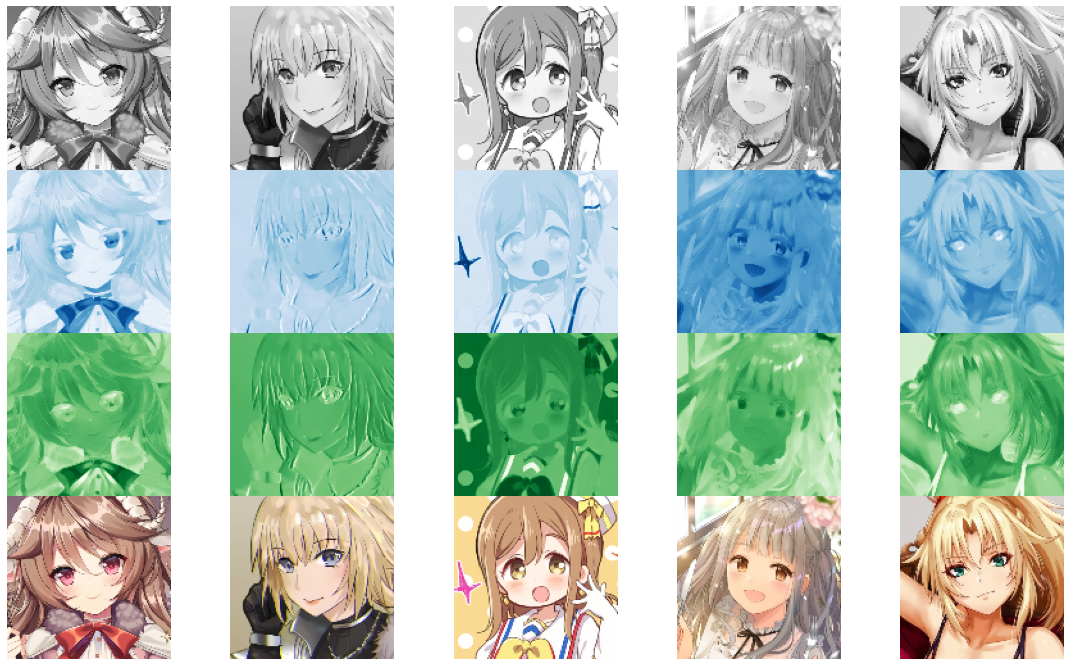

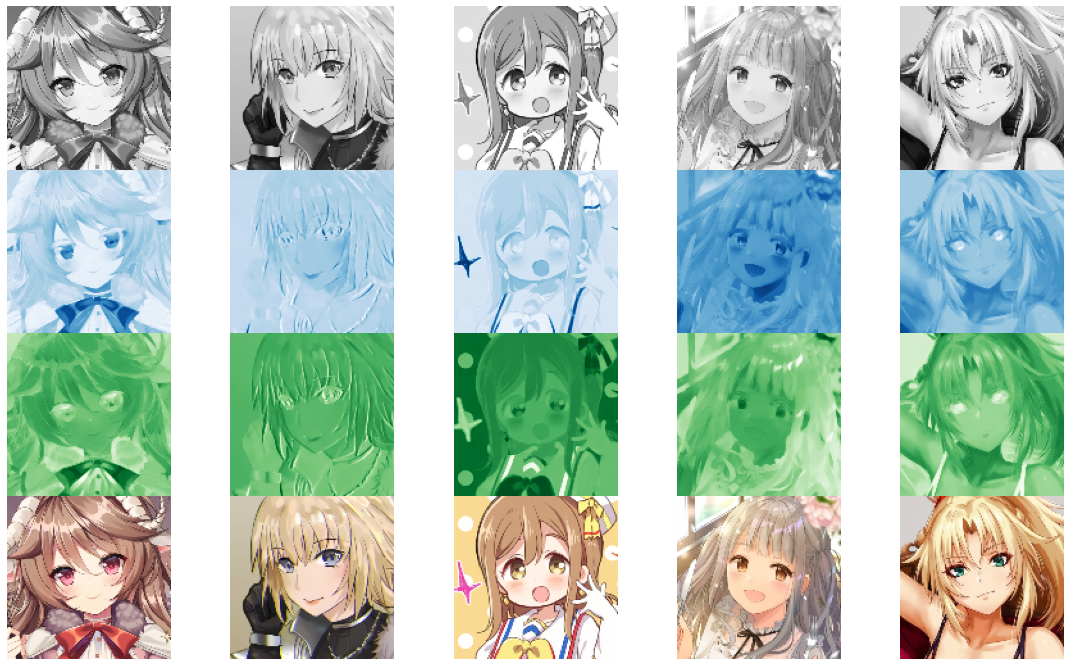

In [10]:

num_examples_to_generate = 9

train_batch_iter = iter(train_images)
train_image_batch, expected_image_batch = next(train_batch_iter)

generateBigBridImage(None, 5, train_images)


## Augmented DataSet Example

/home/voldie/.local/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/home/voldie/.local/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 26 pixels
  return func(*args, **kwargs)


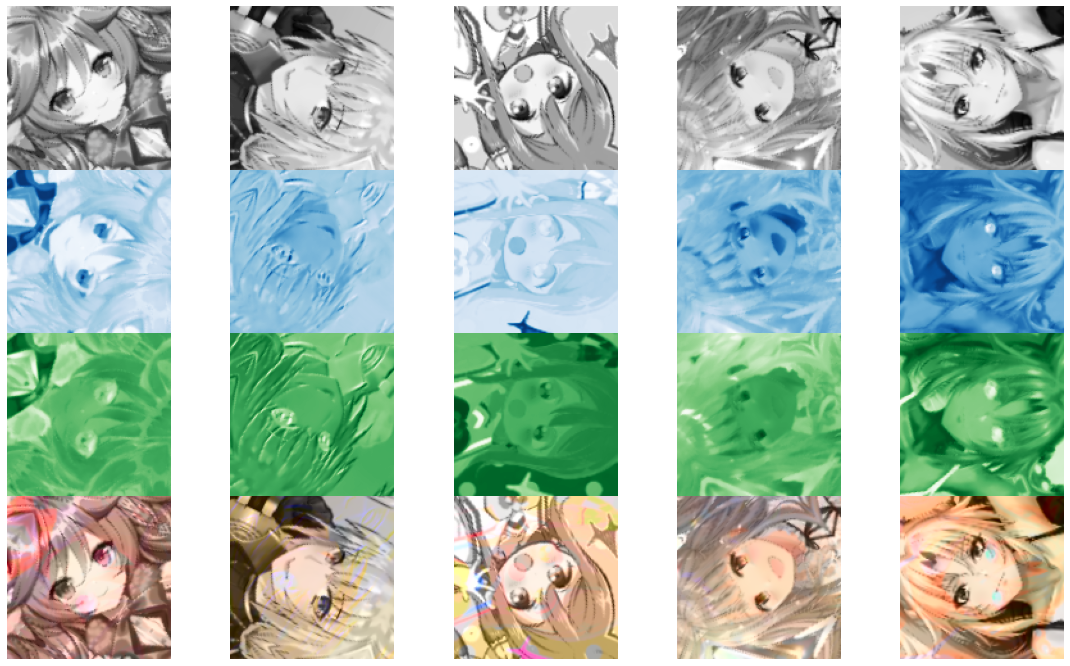

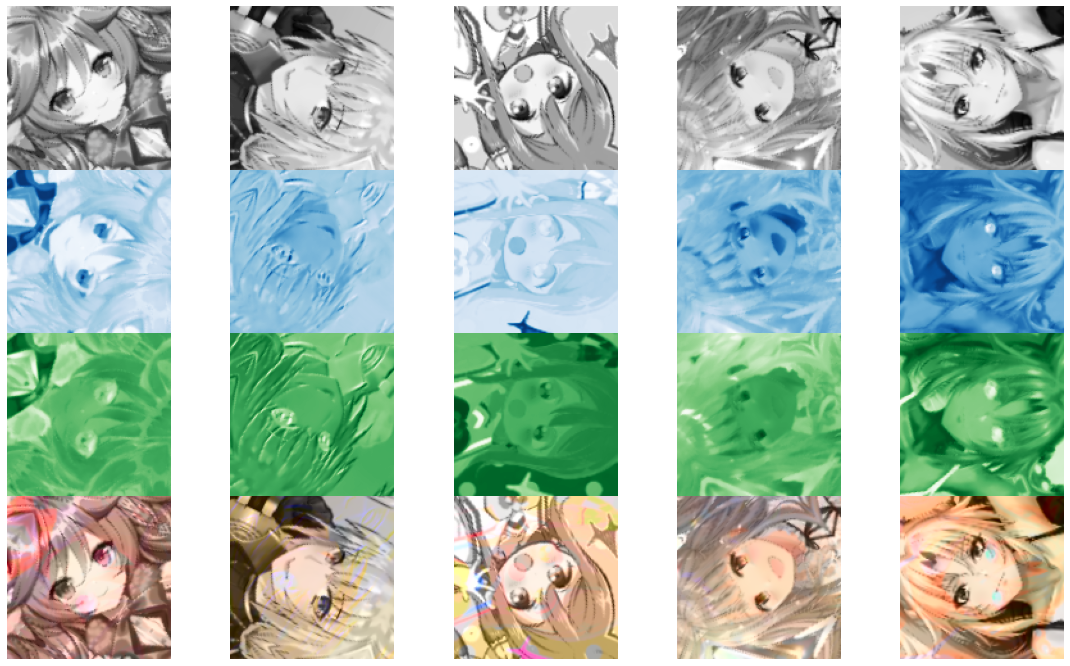

In [11]:
generateBigBridImage(None, 5, trainAugmentedDS)

## Create Model

In [12]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    number_layer_offset = hp.Int('number_layers', min_value=2, max_value=6, step=1)
    max_layers = 3

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - number_layer_offset, 0)
    num_layers = max(1, min(num_layers, max_layers))

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=4, max_value=8, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

        model.add(layers.Conv2D(filters=filter_size, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2))
        model.add(layers.ReLU(dtype='float32'))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.Flatten())
    hp_kernel_filter_size_latent = hp.Int('kernel_filter_latent', min_value=6, max_value=9, step=1)
    model.add(layers.Conv2D(2 ** hp_kernel_filter_size_latent, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))
    model.add(layers.Conv2D(2 ** (hp_kernel_filter_size_latent - 1), (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=9, step=1)

    #upscale_number_layer_offset = hp.Int('upscale_number_layer_offset', min_value=4, max_value=6, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

    model.add(layers.Conv2D(2, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))
    
    mse_magnitude = hp.Float('mse_magnitude', 0, 1.0, step=0.1, default=0.0)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    def ssim_loss(y_true, y_pred):
        return (1.0 - mse_magnitude) * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))) + mse_magnitude * tf.keras.losses.mean_squared_error(y_true, y_pred)

    model.compile(optimizer=hp_optimizer,
                  loss=ssim_loss,
                  metrics=[ssim_loss,'accuracy'])

    return model


## Hyperparameter

In [13]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def model_builder(hp):
    model = create_model(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=3,
                     factor=5,
                     directory=os.path.join(root_dir, 'cache'),
                     project_name=str.format('Colorizing-ColorSpace:LAB - {0}', "Stylized"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_ds.take(1000), epochs=EPOCHS, batch_size=BATCH_SIZE,
            callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], validation_data=train_ds.skip(1000).take(150), verbose=1)
            
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


INFO:tensorflow:Reloading Oracle from existing project result/stylized_colorizing_lab_color_space/cache/Colorizing-ColorSpace:LAB - Stylized/oracle.json
INFO:tensorflow:Reloading Tuner from result/stylized_colorizing_lab_color_space/cache/Colorizing-ColorSpace:LAB - Stylized/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     1280      
                                                                 
 re_lu_14 (ReLU)             (None, 128, 128, 128)     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 re_lu_15 (ReLU)             (None, 64, 64, 128)       0         
                                                          

## Train the Model

In [14]:
def showResult(model, batchImage, maxNumImages=6):

    output = model.predict(batchImage)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 4 * 2))
    for image in batchImage:
        for i in range(nrElements):
            trainImage, expectedImage = image

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = expectedImage[i][:, :, :] * 128

            ax = plt.subplot(4, maxNumImages, i + 1)
            plt.imshow((asarray(lab2rgb(canvas)).astype(dtype='float32')))
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 1 + i + 1)
            plt.imshow(output[i, :, :, 0], cmap='Blues')
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 2 + i + 1)
            plt.imshow(output[i, :, :, 1], cmap='Greens')
            plt.axis("off")

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = output[i][:, :, :]

            ax = plt.subplot(4, maxNumImages, maxNumImages * 3 + 1 + i)
            plt.imshow(asarray(lab2rgb(canvas)).astype(dtype='float32'))
            plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData
        self.trainSet = self.trainData.take(1)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig(os.path.join(root_dir, "animeColorLAB{0}.png".format(epoch)))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig(os.path.join(root_dir, "animeColorLABBig{0}.png".format(epoch)))


In [15]:

checkpoint_path = os.path.join(root_dir, "checkpoints/cp.ckpt")

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

model_history = model.fit(train_images,
                          epochs=EPOCHS,
                          batch_size=1,
                          validation_data=val_ds,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])

model.save_weights(checkpoint_path)


Epoch 1/8


2023-05-20 08:18:24.224826: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-05-20 08:18:28.824576: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


78972/78972 [==============================] - 9965s 126ms/step - loss: 0.0631 - ssim_loss: 0.0631 - accuracy: 0.5820 - val_loss: 0.0800 - val_ssim_loss: 0.0800 - val_accuracy: 0.5533
Epoch 2/8
78972/78972 [==============================] - 9523s 121ms/step - loss: 0.0608 - ssim_loss: 0.0608 - accuracy: 0.6194 - val_loss: 0.0803 - val_ssim_loss: 0.0803 - val_accuracy: 0.5469
Epoch 3/8
78972/78972 [==============================] - 9158s 116ms/step - loss: 0.0603 - ssim_loss: 0.0603 - accuracy: 0.6361 - val_loss: 0.0805 - val_ssim_loss: 0.0805 - val_accuracy: 0.5483
Epoch 4/8
78972/78972 [==============================] - 9320s 118ms/step - loss: 0.0600 - ssim_loss: 0.0600 - accuracy: 0.6448 - val_loss: 0.0807 - val_ssim_loss: 0.0807 - val_accuracy: 0.5483
Epoch 5/8
78972/78972 [==============================] - 8561s 108ms/step - loss: 0.0597 - ssim_loss: 0.0597 - accuracy: 0.6486 - val_loss: 0.0809 - val_ssim_loss: 0.0809 - val_accuracy: 0.5547
Epoch 6/8
78972/78972 [=================

In [16]:
model.save("dc-anime-colorization-lab.h5")

# Image Colorization Result

In [17]:
fig = showResult(model, train_images.take(1))
plt.show()

1/1 [==============================] - 1s 552ms/step


In [19]:
anim_file = os.path.join(root_dir, 'anime-colorizing-lab.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(root_dir, 'animeColorLABBig*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


In [20]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    fig.show()
    fig.savefig(title + ".png")


/tmp/ipykernel_1245862/3754951874.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


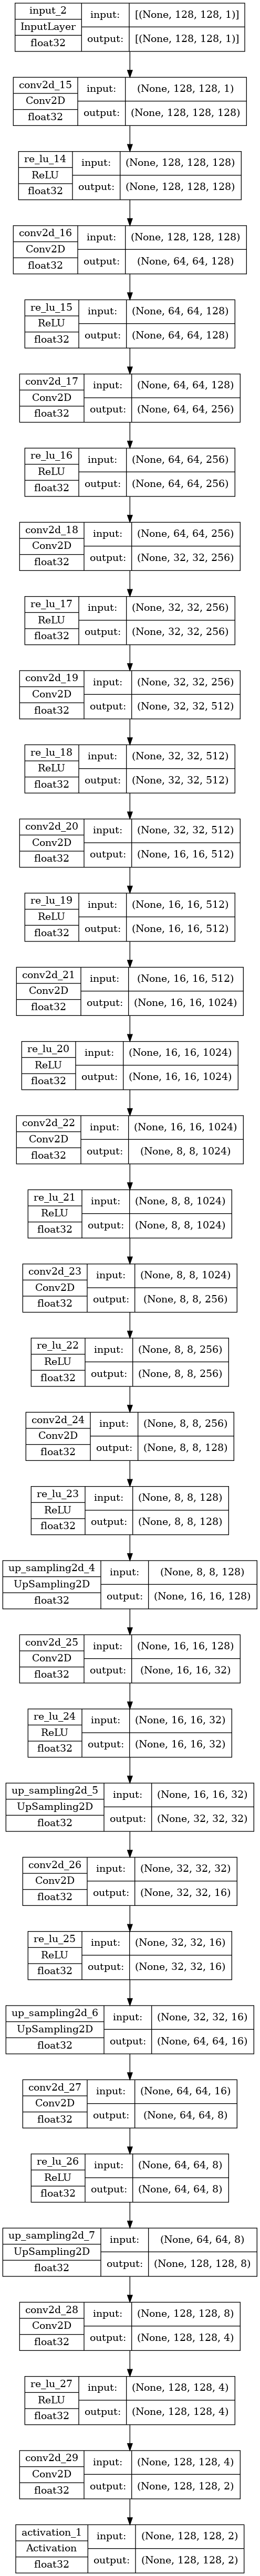

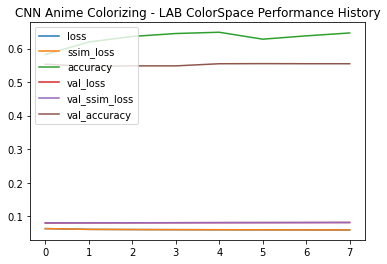

In [21]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing - LAB ColorSpace"))

tf.keras.utils.plot_model(
    model, to_file=os.path.join(root_dir, str.format('{0}.png', "Anime Colorizing - LAB ColorSpace")), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
